## **Identifying Fraudulent Transactions:**  

**Objective of the Project:**

The objective of this project is to build a predictive model that classifies whether a given transaction is fraudulent or legitimate.

Detecting fraudulent transactions is critical in the financial and banking sectors to minimize monetary losses, protect customers, and maintain trust.

**Business Goal:**

Maximize fraud detection accuracy (high recall) while maintaining a low false positive rate (balanced precision-recall trade-off).


I imported the jsonlines library because the data is stored in Json Lines format, where each line was a separate JSON object.
This library helps read and process the data easily and efficiently, especially when working with large files.

In [1]:
pip install jsonlines


In [2]:
import jsonlines
import pandas as pd
from datetime import datetime
#import sys
#print(sys.executable)

data = []

with jsonlines.open("/content/transactions data.txt") as reader:
  for obj in reader.iter(skip_invalid=True): # Used Skip_invalid as True to ignore any error related to extra characters after valid JSON Object
    data.append(obj)

data = pd.DataFrame(data)



## **Data Over View and Cleaning**:

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748942 entries, 0 to 748941
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             748942 non-null  object 
 1   customerId                748942 non-null  object 
 2   creditLimit               748942 non-null  float64
 3   availableMoney            748942 non-null  float64
 4   transactionDateTime       748942 non-null  object 
 5   transactionAmount         748942 non-null  float64
 6   merchantName              748942 non-null  object 
 7   acqCountry                748942 non-null  object 
 8   merchantCountryCode       748942 non-null  object 
 9   posEntryMode              748942 non-null  object 
 10  posConditionCode          748942 non-null  object 
 11  merchantCategoryCode      748942 non-null  object 
 12  currentExpDate            748942 non-null  object 
 13  accountOpenDate           748942 non-null  o

In [4]:
# Count unique values in each column
unique_counts = data.nunique()

# Display the result
print("Unique value count per column:")
print(unique_counts)

Unique value count per column:
accountNumber                 4797
customerId                    4797
creditLimit                     10
availableMoney              501684
transactionDateTime         740107
transactionAmount            65310
merchantName                  2488
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1788
dateOfLastAddressChange       2151
cardCVV                        899
enteredCVV                     975
cardLast4Digits               5090
transactionType                  4
echoBuffer                       1
currentBalance              469025
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch

#### **Missing Values and Empty Strings**:
The dataset was first checked for missing values using the isnull().sum() method.
Additionally, some columns contained empty strings or whitespace characters instead of actual null values. Regular expressions (Regex) were used to detect and handle such columns appropriately.

In [5]:
# Check remaining missing values
missing_summary = data.isnull().sum()
print(missing_summary)

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64


In [6]:
import numpy as np

empty_counts_sum = data.replace(r'^\s*$', np.nan, regex=True).isna().sum()
print(empty_counts_sum[empty_counts_sum > 0])


/tmp/ipython-input-1560404081.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_counts_sum = data.replace(r'^\s*$', np.nan, regex=True).isna().sum()


acqCountry               4348
merchantCountryCode       698
posEntryMode             3876
posConditionCode          378
transactionType           666
echoBuffer             748942
merchantCity           748942
merchantState          748942
merchantZip            748942
posOnPremises          748942
recurringAuthInd       748942
dtype: int64


<Axes: xlabel='isFraud', ylabel='transactionAmount'>

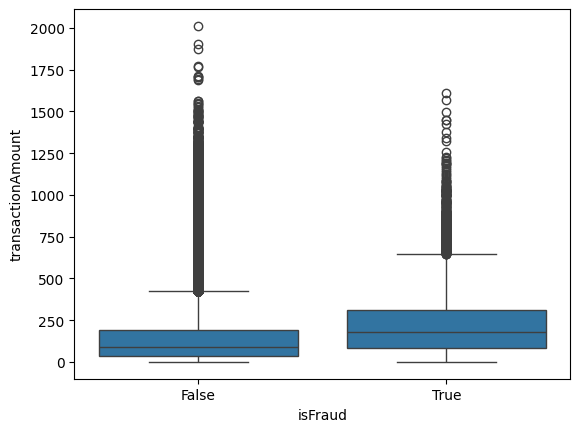

In [7]:
import seaborn as sns
sns.boxplot(x='isFraud', y='transactionAmount', data=data)


**Some columns — like echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, and recurringAuthInd — contained only empty or missing values.
Since they don’t provide any useful information for fraud detection and would only increase processing time and memory usage, I decided to remove them from the dataset.**

In [8]:

data = data.drop(columns=['customerId'])

In [9]:
cols_to_drop = [
    'echoBuffer', 'merchantCity', 'merchantState',
    'merchantZip', 'posOnPremises', 'posConditionCode',  'recurringAuthInd'
]
data = data.drop(columns=cols_to_drop)

In [10]:
import pandas as pd

date_cols = ["dateOfLastAddressChange", "accountOpenDate", "currentExpDate", "transactionDateTime"]

# Convert columns to datetime
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT

# Check result
print(data[date_cols].dtypes)


/tmp/ipython-input-4151465552.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT


dateOfLastAddressChange    datetime64[ns]
accountOpenDate            datetime64[ns]
currentExpDate             datetime64[ns]
transactionDateTime        datetime64[ns]
dtype: object


### **Exploratory Data Analysis:**

**Checking Skewness and Outliers**:



creditLimit          2.459459
availableMoney       2.912839
transactionAmount    2.040563
currentBalance       4.211631
dtype: float64


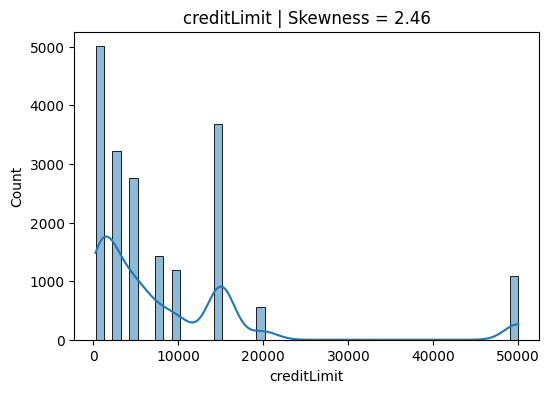

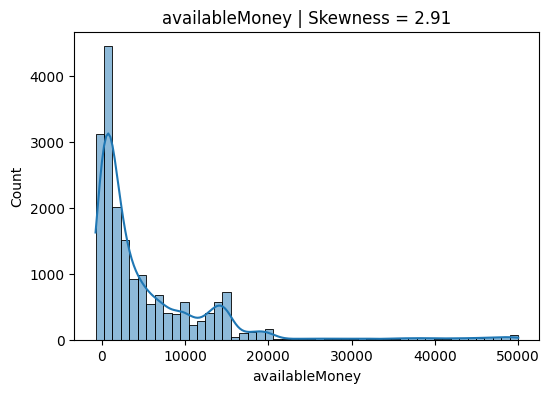

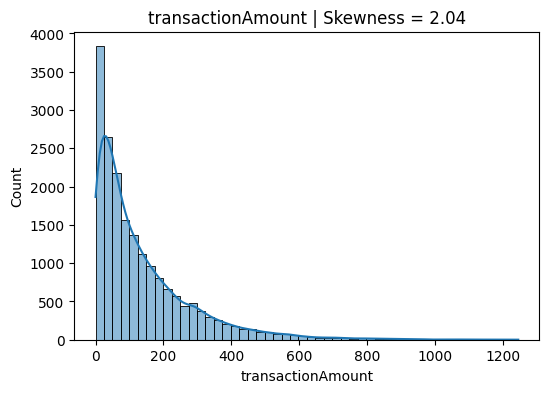

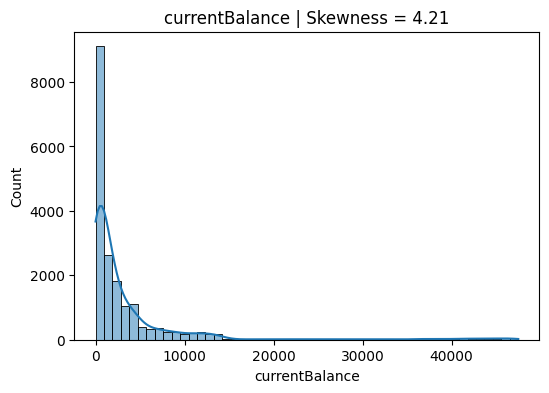

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

# Calculate skewness
skew_vals = data[num_cols].skew()
print(skew_vals)

# Plot histograms + KDE for visualization
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=50)
    plt.title(f"{col} | Skewness = {data[col].skew():.2f}")
    plt.show()


The variables - Current Amount, Transaction Amount, Available Money are rightly skewed and  applying log1p transformation will help us in removing skewness and make data ditribution normal.  

**Analyzing the Impact of CVV Mismatch on Fraudulent Transactions**

In [11]:
# Create new column checking equality
data['cvv_match'] = data['cardCVV'] == data['enteredCVV']
data['cvv_match'].value_counts()


,count
cvv_match,
True,742258
False,6684


In [12]:
# Filter mismatches
mismatches = data.loc[~data['cvv_match']]

# Group by merchant and count mismatches
merchant_mismatch_counts = mismatches.groupby('merchantCategoryCode').size().reset_index(name='mismatch_count').sort_values(by='mismatch_count', ascending=False)

print(merchant_mismatch_counts)

    merchantCategoryCode  mismatch_count
14         online_retail            1705
4               fastfood             945
3          entertainment             674
5                   food             627
13          online_gifts             617
17             rideshare             446
11                hotels             255
18         subscriptions             195
7                   fuel             192
16         personal care             177
1                   auto             176
10                health             165
12            mobileapps             133
0                airline             119
15  online_subscriptions             107
6          food_delivery              85
8              furniture              44
2            cable/phone              20
9                    gym               2


The merchant category analysis revealed significant data mismatches, particularly in Online Retail (152), Fast Food (90), and Food (61). Such inconsistencies may be indicative of fraudulent behavior, as high-frequency or online transactions are often used by fraudsters to test stolen cards.

These mismatches could arise from card-not-present activities. These categories should be prioritized for anomaly detection or model-based fraud risk scoring.

Conversely, categories like Airline and Fuel show lower mismatch counts, suggesting greater consistency and lower immediate fraud risk.

In [13]:
data = data.drop(columns=['cardCVV', 'enteredCVV', 'cardLast4Digits'])

### **Analyzing Fraud Rate by POS Entry Mode**

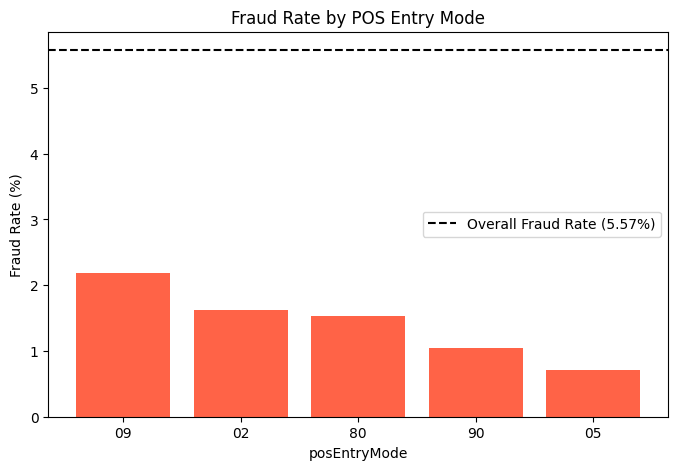

In [ ]:
counts = data['posEntryMode'].value_counts()
counts
data.groupby('posEntryMode')['isFraud'].mean().sort_values(ascending=False)

import matplotlib.pyplot as plt

fraud_rates = {
    "09": 0.021909,
    "02": 0.016152,
    "80": 0.015385,
    "90": 0.010397,
    "05": 0.007058
}

plt.figure(figsize=(8,5))
plt.bar(fraud_rates.keys(), [v*100 for v in fraud_rates.values()], color="tomato")
plt.axhline(5.5749, color="black", linestyle="--", label="Overall Fraud Rate (5.57%)")

plt.xlabel("posEntryMode")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by POS Entry Mode")
plt.legend()
plt.show()



The fraud rate varies by POS entry mode, with mode 09 showing the highest fraud rate (~2.2%), while mode 05 exhibits the lowest.
However, all modes have a fraud rate below the overall average of 5.57%, suggesting that POS-based fraud is relatively contained compared to other channels.
This may indicate stronger fraud controls or verification mechanisms within physical or chip-based POS transactions.”

**Customer_Spending_Patterns**

In [14]:
data["credit_utilization"] = data["transactionAmount"] / (data["availableMoney"] + 1)

**Merchant Level Risk Features**

In [15]:
data["merchant_total_txns"] = data.groupby("merchantName")["transactionAmount"].transform("count")

In [16]:
data["merchant_avg_amt"] = data.groupby("merchantName")["transactionAmount"].transform("mean")

In [17]:
data["merchant_fraud_rate"] = data.groupby("merchantName")["isFraud"].transform("mean")

**Transaction_level_Patterns**

In [18]:
data["avg_txn_amt_card"] = data.groupby("accountNumber")["transactionAmount"].transform("mean")
data["std_txn_amt_card"] = data.groupby("accountNumber")["transactionAmount"].transform("std")
data["amt_deviation"] = (data["transactionAmount"] - data["avg_txn_amt_card"]) / (data["std_txn_amt_card"] + 1)

**Lets identify ranges where fraud rate increases for Creditlimit, transactionAmount and currentBalance.**

In [ ]:

# Define your columns of interest
cols_to_check = ['creditLimit', 'transactionAmount', 'currentBalance']

# Set the step size for thresholds (adjust for granularity)
threshold_steps = 20  # percentiles from 10% to 90%

# Loop over each column
for col in cols_to_check:
    print(f"\n📊 Fraud Rate Analysis for: {col}")
    print("-" * 40)

    # Get min and max thresholds using percentiles
    for percentile in range(10, 100, threshold_steps):
        threshold = data[col].quantile(percentile / 100)

        fraud_rate_above = data[data[col] > threshold]['isFraud'].mean()
        fraud_rate_below = data[data[col] <= threshold]['isFraud'].mean()

        print(f"Threshold > {percentile}% ({threshold:.2f}) → Fraud Rate: {fraud_rate_above:.4f}")



📊 Fraud Rate Analysis for: creditLimit
----------------------------------------
Threshold > 10% (500.00) → Fraud Rate: 0.0139
Threshold > 30% (2500.00) → Fraud Rate: 0.0112
Threshold > 50% (5000.00) → Fraud Rate: 0.0093
Threshold > 70% (10000.00) → Fraud Rate: 0.0086
Threshold > 90% (15000.00) → Fraud Rate: 0.0012

📊 Fraud Rate Analysis for: transactionAmount
----------------------------------------
Threshold > 10% (8.75) → Fraud Rate: 0.0154
Threshold > 30% (41.98) → Fraud Rate: 0.0174
Threshold > 50% (86.66) → Fraud Rate: 0.0201
Threshold > 70% (163.02) → Fraud Rate: 0.0220
Threshold > 90% (328.59) → Fraud Rate: 0.0269

📊 Fraud Rate Analysis for: currentBalance
----------------------------------------
Threshold > 10% (41.69) → Fraud Rate: 0.0143
Threshold > 30% (376.50) → Fraud Rate: 0.0152
Threshold > 50% (1086.97) → Fraud Rate: 0.0142
Threshold > 70% (2593.46) → Fraud Rate: 0.0111
Threshold > 90% (8532.53) → Fraud Rate: 0.0074


Fraud rate remains relatively stable (~1.5–1.7%) until very high credit limits  20,000.

A sharp rise at 90% suggests that very high credit limits are associated with elevated fraud risk — possibly due to opportunistic misuse.

**Insight:** Monitor accounts with exceptionally high credit limits, as they show twice the average fraud rate.

Fraud rate steadily increases with transaction size.
With $329, fraud rate more than doubles from the base level.

**Insight:** Larger transactions are consistently riskier — a clear positive relationship between amount and fraud likelihood.

Fraud rates rise with higher transaction amounts and credit limits, showing that larger transactions and high-limit accounts are more prone to fraud.

### **TOP 10 MERCHANTS BY THE FRAUD RATE:**

In [19]:
data['fraud_amount'] = data['transactionAmount'] * data['isFraud']

merchant_fraud = (
    data.groupby('merchantName', as_index=False)
      .agg(
          total_txns=('isFraud', 'count'),
          fraud_txns=('isFraud', 'sum'),
          fraud_rate=('isFraud', 'mean'),
          fraud_amount=('fraud_amount', 'sum')
      )
      .sort_values(by='fraud_rate', ascending=False)
)

merchant_fraud.head(8)


,merchantName,total_txns,fraud_txns,fraud_rate,fraud_amount
918,In-N-Out #949129,83,10,0.120482,1795.32
41,American Airlines,2989,294,0.098361,49477.81
914,In-N-Out #863086,96,9,0.093750,1793.53
885,In-N-Out #422833,103,9,0.087379,682.33
887,In-N-Out #463194,92,8,0.086957,833.18
891,In-N-Out #567597,84,7,0.083333,2329.64
2286,Walgreens #475572,27,2,0.074074,315.62
916,In-N-Out #899468,100,7,0.070000,1344.90


Analysed merchant level patterns, American Airlines Showed high fraud rate and followed by IN AND OUT,  indicating vulnerablities at specific outlets.

### **TOP 10 MERCHANTS BY THE FRAUD TRANSACTIONS  FRAUD AMOUNT:**

In [20]:
top_merchants = (
    data.assign(fraud_amount=data['transactionAmount'] * data['isFraud'])
        .groupby('merchantName', as_index=False)
        .agg(
            total_txns=('isFraud', 'size'),
            fraud_txns=('isFraud', 'sum'),
            total_amount=('transactionAmount', 'sum'),
            fraud_amount=('fraud_amount', 'sum')
        )
        .assign(fraud_rate=lambda d: d['fraud_txns'] / d['total_txns'])
        .nlargest(10, 'fraud_txns')[['merchantName', 'fraud_rate', 'fraud_txns', 'fraud_amount']]
)

print(top_merchants)


       merchantName  fraud_rate  fraud_txns  fraud_amount
1060           Lyft    0.029408         733     170840.38
2474       ebay.com    0.039290         622     134460.51
597   Fresh Flowers    0.066659         553     138598.46
2084           Uber    0.019950         499     119014.73
2485    walmart.com    0.027216         432     107189.81
2472  cheapfast.com    0.026769         424     101007.09
2483    staples.com    0.024741         394      98648.85
2482      sears.com    0.024575         386      91087.48
2480    oldnavy.com    0.023247         371      87729.16
2468    alibaba.com    0.023020         367      94099.78


“**The top merchants by fraud volume include Ebay, Lyft,Uber, Sears and Walmart, Staples and discount.

Fraud losses are concentrated among large, high-volume merchants, with several well-known e-commerce and transportation platforms. (From 22k to 57K)  




Fraud risk isn’t just about frequency — it’s a combination of rate, transaction volume, and dollar loss.

In [21]:
data['Trans_Hour'] = data['transactionDateTime'].dt.hour
data["is_night"] = data["Trans_Hour"].isin([0,1,2,3,4,5]).astype(int)

 ### **Merchants list by hourly and Temporal Patterns**  

In [22]:
import numpy as np

TOP_K = 3  # adjust as needed

# Aggregate including accountNumber
agg = (
    data.assign(
        isFraud=lambda d: d['isFraud'].astype('i1'),
        fraud_amount=lambda d: d['transactionAmount'] * d['isFraud'],
    )
    .groupby(['Trans_Hour', 'merchantName', 'accountNumber'], as_index=False)
    .agg(
        total_txns=('isFraud', 'size'),
        fraud_txns=('isFraud', 'sum'),
        total_amount=('transactionAmount', 'sum'),
        fraud_amount=('fraud_amount', 'sum'),
    )
)

# % fraud amount out of total amount (safe divide)
agg['pct_fraud_amount'] = np.divide(
    agg['fraud_amount'],
    agg['total_amount'],
    out=np.zeros(len(agg), dtype=float),
    where=agg['total_amount'].ne(0)
)

# Top-K merchants per hour by fraud_amount
top_idx = (
    agg.groupby('Trans_Hour')['fraud_amount']
       .nlargest(TOP_K)
       .index.get_level_values(1)
)

top_merchants_per_hour = (
    agg.loc[top_idx]
       .sort_values(['Trans_Hour', 'fraud_amount'], ascending=[True, False])
)

# Preview
top_merchants_per_hour.head(25)




,Trans_Hour,merchantName,accountNumber,total_txns,fraud_txns,total_amount,fraud_amount,pct_fraud_amount
6299,0,Fresh Flowers,380680241,168,19,22400.15,3225.57,0.143998
1784,0,American Airlines,472288969,13,13,2101.82,2101.82,1.000000
18351,0,ebay.com,700725639,13,13,1824.94,1824.94,1.000000
27148,1,Fresh Flowers,380680241,171,28,26802.61,8472.73,0.316116
23534,1,Blue Mountain Online Services,380680241,176,7,26381.07,2296.12,0.087037
39086,1,ebay.com,700725639,10,10,1562.59,1562.59,1.000000
47717,2,Fresh Flowers,380680241,192,21,27988.91,4922.61,0.175877
60542,2,oldnavy.com,846466728,4,2,2798.89,1797.76,0.642312
43267,2,American Airlines,472288969,12,12,1626.71,1626.71,1.000000
68360,3,Fresh Flowers,380680241,167,19,21906.46,4939.81,0.225496


Together they give insight into velocity and volume of spending.

### **FEATURE ENGINEERING**

**Total Transactions per account per hour**  

In [23]:
data['txn_count_hour'] = (
    data.groupby(['accountNumber', 'Trans_Hour'])['transactionAmount']
      .transform('count')
)


In [24]:
# Sum of amounts per account per hour
data['amt_sum_hour'] = (
    data.groupby(['accountNumber', 'Trans_Hour'])['transactionAmount']
      .transform('sum')
)

In [25]:
# Drop the original columns
df = data.drop(['currentExpDate', 'accountOpenDate','expirationDateKeyInMatch'], axis=1)

In [26]:
df

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,...,merchant_avg_amt,merchant_fraud_rate,avg_txn_amt_card,std_txn_amt_card,amt_deviation,fraud_amount,Trans_Hour,is_night,txn_count_hour,amt_sum_hour
0,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,rideshare,...,145.722478,0.019950,47.000000,46.688487,1.080974,0.0,14,0,1,98.55
1,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,entertainment,...,144.716185,0.005373,47.000000,46.688487,0.576869,0.0,5,1,1,74.51
2,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,mobileapps,...,5.882500,0.000000,47.000000,46.688487,-0.828921,0.0,9,0,1,7.47
3,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,mobileapps,...,5.882500,0.000000,47.000000,46.688487,-0.828921,0.0,2,1,1,7.47
4,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,fastfood,...,139.650680,0.009709,107.255455,147.101379,-0.243586,0.0,21,0,1,71.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748937,732628017,7500.0,7230.34,2016-06-10 22:22:57,256.49,Franks Deli,US,US,05,food,...,140.242177,0.012092,115.367586,110.362271,1.267237,0.0,22,0,2,264.02
748938,732628017,7500.0,6973.85,2016-06-11 19:50:50,7.53,Play Store,US,US,05,mobileapps,...,5.882500,0.000000,115.367586,110.362271,-0.968349,0.0,19,0,2,14.44
748939,732628017,7500.0,6966.32,2016-06-26 02:33:18,164.89,1st Restaurant,US,US,02,food,...,138.022527,0.012092,115.367586,110.362271,0.444697,0.0,2,1,2,180.61
748940,732628017,7500.0,7500.00,2016-07-08 14:59:07,109.78,South Steakhouse #157238,US,US,05,food,...,151.900276,0.011307,115.367586,110.362271,-0.050175,0.0,14,0,2,117.31


In [27]:
df = df.drop(['dateOfLastAddressChange', 'transactionDateTime'], axis=1)
df

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,transactionType,...,merchant_avg_amt,merchant_fraud_rate,avg_txn_amt_card,std_txn_amt_card,amt_deviation,fraud_amount,Trans_Hour,is_night,txn_count_hour,amt_sum_hour
0,737265056,5000.0,5000.00,98.55,Uber,US,US,02,rideshare,PURCHASE,...,145.722478,0.019950,47.000000,46.688487,1.080974,0.0,14,0,1,98.55
1,737265056,5000.0,5000.00,74.51,AMC #191138,US,US,09,entertainment,PURCHASE,...,144.716185,0.005373,47.000000,46.688487,0.576869,0.0,5,1,1,74.51
2,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,5.882500,0.000000,47.000000,46.688487,-0.828921,0.0,9,0,1,7.47
3,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,5.882500,0.000000,47.000000,46.688487,-0.828921,0.0,2,1,1,7.47
4,830329091,5000.0,5000.00,71.18,Tim Hortons #947751,US,US,02,fastfood,PURCHASE,...,139.650680,0.009709,107.255455,147.101379,-0.243586,0.0,21,0,1,71.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748937,732628017,7500.0,7230.34,256.49,Franks Deli,US,US,05,food,PURCHASE,...,140.242177,0.012092,115.367586,110.362271,1.267237,0.0,22,0,2,264.02
748938,732628017,7500.0,6973.85,7.53,Play Store,US,US,05,mobileapps,PURCHASE,...,5.882500,0.000000,115.367586,110.362271,-0.968349,0.0,19,0,2,14.44
748939,732628017,7500.0,6966.32,164.89,1st Restaurant,US,US,02,food,PURCHASE,...,138.022527,0.012092,115.367586,110.362271,0.444697,0.0,2,1,2,180.61
748940,732628017,7500.0,7500.00,109.78,South Steakhouse #157238,US,US,05,food,PURCHASE,...,151.900276,0.011307,115.367586,110.362271,-0.050175,0.0,14,0,2,117.31


In [28]:
merchant_check = (
    df.groupby(['accountNumber', 'Trans_Hour'])['merchantCategoryCode']
      .nunique()
      .reset_index(name='unique_merchant_categories')
)

merchant_check

,accountNumber,Trans_Hour,unique_merchant_categories
0,100088067,0,5
1,100088067,1,3
2,100088067,2,1
3,100088067,3,4
4,100088067,4,3
...,...,...,...
88518,999389635,13,1
88519,999389635,14,1
88520,999389635,15,1
88521,999389635,16,1


In [29]:
df['is_reverse'] = (df['transactionType'] == 'REVERSAL').astype(int)
df['is_multiswipe'] = (df['transactionType'] == 'MULTISWIPE').astype(int)

account_features = (
    df.groupby('accountNumber')
      .agg(
          reverse_count=('is_reverse', 'sum'),
          multiswipe_count=('is_multiswipe', 'sum'),
          total_txn=('transactionAmount', 'count')
      )
      .reset_index()
)


In [30]:
night_features = (
    df.groupby('accountNumber')['is_night']
      .sum()
      .reset_index(name='night_txn_count')
)

In [31]:
category_sum = (
    df.groupby('merchantCategoryCode')['transactionAmount']
      .sum()
      .reset_index(name='category_total_txn_amt')
)


In [32]:
fraud_sum_account = (
    df.groupby('accountNumber')['fraud_amount']
      .sum()
      .reset_index(name='fraud_sum_account')
)


In [33]:
# Fraud flag
df['is_fraud'] = (df['fraud_amount'] > 0).astype(int)

# Reverse and multiswipe flags
df['is_reverse'] = (df['transactionType'] == 'REVERSAL').astype(int)
df['is_multiswipe'] = (df['transactionType'] == 'MULTISWIPE').astype(int)

# Fraud amount per account
fraud_sum = df.groupby('accountNumber')['fraud_amount'].sum().reset_index(name='fraud_sum_account')

# Total amount per merchant category
cat_sum = df.groupby('merchantCategoryCode')['transactionAmount'].sum().reset_index(name='category_total_txn_amt')

# Night transactions per account
night_sum = df.groupby('accountNumber')['is_night'].sum().reset_index(name='night_txn_count')

# Reverse & multiswipe totals per account
rev_multi = df.groupby('accountNumber').agg(
    reverse_amt=('transactionAmount', lambda x: x[df.loc[x.index, 'is_reverse']==1].sum()),
    multiswipe_amt=('transactionAmount', lambda x: x[df.loc[x.index, 'is_multiswipe']==1].sum())
).reset_index()

# Merge all features back
df = (df.merge(fraud_sum, on='accountNumber', how='left')
        .merge(cat_sum, on='merchantCategoryCode', how='left')
        .merge(night_sum, on='accountNumber', how='left')
        .merge(rev_multi, on='accountNumber', how='left'))


In [34]:
df

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,transactionType,...,txn_count_hour,amt_sum_hour,is_reverse,is_multiswipe,is_fraud,fraud_sum_account,category_total_txn_amt,night_txn_count,reverse_amt,multiswipe_amt
0,737265056,5000.0,5000.00,98.55,Uber,US,US,02,rideshare,PURCHASE,...,1,98.55,0,0,0,0.0,7301749.74,2,0.0,0.0
1,737265056,5000.0,5000.00,74.51,AMC #191138,US,US,09,entertainment,PURCHASE,...,1,74.51,0,0,0,0.0,11337289.17,2,0.0,0.0
2,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,1,7.47,0,0,0,0.0,84388.96,2,0.0,0.0
3,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,1,7.47,0,0,0,0.0,84388.96,2,0.0,0.0
4,830329091,5000.0,5000.00,71.18,Tim Hortons #947751,US,US,02,fastfood,PURCHASE,...,1,71.18,0,0,0,0.0,15632600.18,2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748937,732628017,7500.0,7230.34,256.49,Franks Deli,US,US,05,food,PURCHASE,...,2,264.02,0,0,0,293.5,10471301.79,8,0.0,0.0
748938,732628017,7500.0,6973.85,7.53,Play Store,US,US,05,mobileapps,PURCHASE,...,2,14.44,0,0,0,293.5,84388.96,8,0.0,0.0
748939,732628017,7500.0,6966.32,164.89,1st Restaurant,US,US,02,food,PURCHASE,...,2,180.61,0,0,0,293.5,10471301.79,8,0.0,0.0
748940,732628017,7500.0,7500.00,109.78,South Steakhouse #157238,US,US,05,food,PURCHASE,...,2,117.31,0,0,0,293.5,10471301.79,8,0.0,0.0


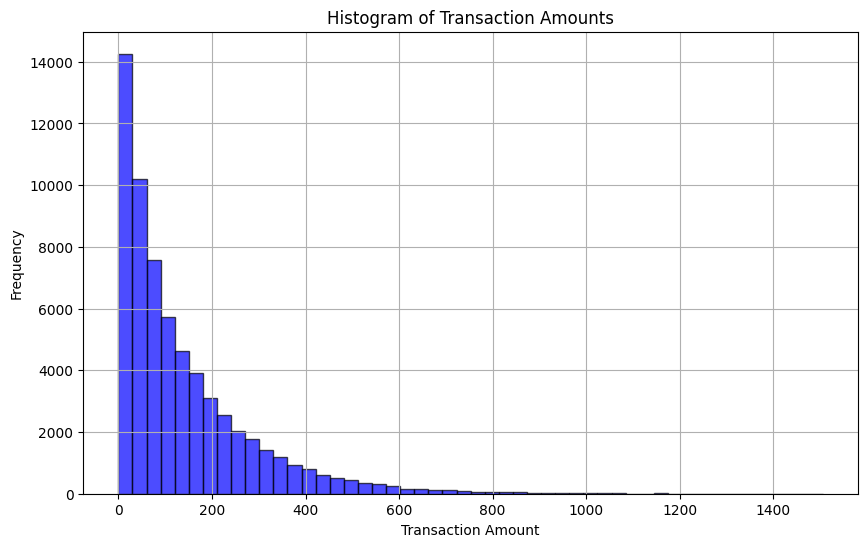

Transaction Amount Summary:
count    63577.000000
mean       138.573092
std        148.143406
min          0.000000
25%         34.720000
50%         89.160000
75%        193.340000
max       1505.850000
Name: transactionAmount, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for transactionAmount
plt.figure(figsize=(10, 6))
plt.hist(df["transactionAmount"], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Statistical description of transactionAmount
transaction_stats = df["transactionAmount"].describe()
print("Transaction Amount Summary:")
print(transaction_stats)

In [35]:
df.columns

Index(['accountNumber', 'creditLimit', 'availableMoney', 'transactionAmount',
       'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'isFraud', 'cvv_match', 'credit_utilization',
       'merchant_total_txns', 'merchant_avg_amt', 'merchant_fraud_rate',
       'avg_txn_amt_card', 'std_txn_amt_card', 'amt_deviation', 'fraud_amount',
       'Trans_Hour', 'is_night', 'txn_count_hour', 'amt_sum_hour',
       'is_reverse', 'is_multiswipe', 'is_fraud', 'fraud_sum_account',
       'category_total_txn_amt', 'night_txn_count', 'reverse_amt',
       'multiswipe_amt'],
      dtype='object')

The histogram above illustrates the distribution of transaction amounts and their frequency. The data shows that transaction peaks occur predominantly for amounts less than **250,** with a mean transaction value of **136.** Additionally, **75%** of users spend **191** or less on their transactions, indicating that the majority of users make transactions below **200**. If later we see any spends above then this 75% it may indicate fraudulent transaction.

### **Data Transformation & Pipeline Setup**  

In [36]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, accuracy_score, f1_score
)
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# =========================
# Assume df already exists with your listed columns
# If not, load it here, e.g.:
# df = pd.read_csv("your_file.csv")
# =========================

# Safety: normalize transactionType and ensure flags exist (no-ops if already present)
df["transactionType"] = df["transactionType"].astype(str).str.upper()
if "is_reverse" not in df.columns:
    df["is_reverse"] = (df["transactionType"] == "REVERSAL").astype(int)
if "is_multiswipe" not in df.columns:
    df["is_multiswipe"] = (df["transactionType"] == "MULTISWIPE").astype(int)
if "merchantName_top" not in df.columns:
    df["merchantName_top"] = df["merchantName"].astype(str)

# =========================
# Target and feature selection (avoid leakage: don't use 'is_fraud' or 'fraud_amount')
# =========================
y_full = df["isFraud"].astype(int).copy()

# CATEGORICAL (string-like)
categorical_cols = [
    "acqCountry","merchantCountryCode","posEntryMode",
    "merchantCategoryCode","transactionType","merchantName_top"
]

# BINARY flags
binary_cols = ["cardPresent","cvv_match","is_night","is_reverse","is_multiswipe"]

# NUMERIC (standard scale)
num_cols = [
    "creditLimit","availableMoney","Trans_Hour",
    "merchant_avg_amt","credit_utilization","avg_txn_amt_card","std_txn_amt_card",
    "amt_deviation"
]

# LOG-NUMERIC (skewed → log1p then scale)
log_num_cols = [
    "transactionAmount","currentBalance","merchant_total_txns",
    "reverse_amt","multiswipe_amt",
    "fraud_sum_account","category_total_txn_amt","night_txn_count",
    "txn_count_hour","amt_sum_hour"
]

# Keep stable order
feature_order = num_cols + log_num_cols + categorical_cols + binary_cols
X_full = df[feature_order].copy()

# =========================
# Split (train/test)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# =========================
# Top-N merchant mapping (train-only)
# =========================
TOP_N = 200
top_merchants = (
    X_train["merchantName_top"].astype(str).value_counts().head(TOP_N).index.tolist()
)

def map_top_other(s, top_list):
    s = s.astype(str)
    return np.where(s.isin(top_list), s, "other")

X_train["merchantName_top"] = map_top_other(X_train["merchantName_top"], top_merchants)
X_test["merchantName_top"]  = map_top_other(X_test["merchantName_top"],  top_merchants)

# =========================
# Preprocessing pipelines
# =========================
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True))
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

log_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num",     numeric_transformer,     num_cols),
        ("log_num", log_numeric_transformer, log_num_cols),
        ("cat",     categorical_transformer, categorical_cols),
        ("bin",     "passthrough",           binary_cols),
    ],
    sparse_threshold=1.0
)

# =========================
# Model pipeline
# =========================
logreg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga"))
])

# =========================
# Threshold tuning on a validation split
# =========================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit on sub-train
logreg_pipe.fit(X_tr, y_tr)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['creditLimit',
                                                   'availableMoney',
                                                   'Trans_Hour',
                                                   'merchant_avg_amt',
                                                   'credit_utilization',
                                                   'avg_txn_amt_card',
                                                   'std_txn_amt_card',
                                                   'amt_deviation']),
                                                 ('log_num',
                                                  Pipeline(steps=...
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['acqCountry',
                                                   'merchantCountryCode',
                                                   'posEntryMode',
                                                   'merchantCategoryCode',
                                                   'transactionType',
                                                   'merchantName_top']),
                                                 ('bin', 'passthrough',
                                                  ['cardPresent', 'cvv_match',
                                                   'is_night', 'is_reverse',
                                                   'is_multiswipe'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga'))])

In [37]:
# Choose threshold on validation by F1 (change to cost if you want)
y_val_proba = logreg_pipe.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
thresholds = np.r_[thresholds, 1.0]
f1 = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1))
best_threshold = float(thresholds[best_idx])
print("Chosen threshold (F1 on validation):", best_threshold)

# Refit on full training
logreg_pipe.fit(X_train, y_train)

# --- Evaluate on TEST with tuned threshold
y_pred_proba_test = logreg_pipe.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

Chosen threshold (F1 on validation): 0.8605922406426585


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


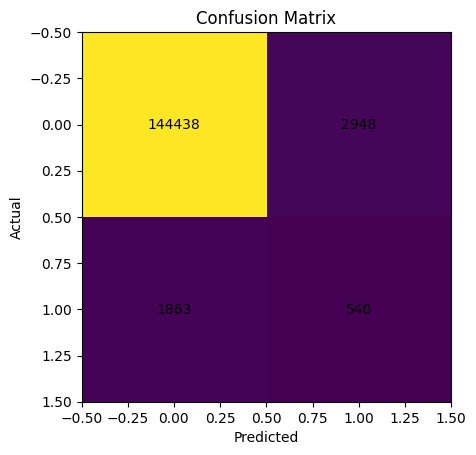

In [38]:
# Optional: quick heatmap (matplotlib only)
cm = confusion_matrix(y_test, y_pred_test)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()


Data is fitting so well on training data, and not able to generalize well on test data, high bias and low variance. We can use xgboost to lower the bias.  

### **Modeling & Hyperparameter Tuning**

**XGBOOST:**

In [39]:
from sklearn.pipeline import Pipeline   # Corrected alias
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# XGBoost pipeline
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),  # reuse your existing preprocessor
    ("model", XGBClassifier(
        n_estimators=700,
        max_depth=5,
        learning_rate=0.04,
        subsample=0.6,
        colsample_bytree=0.6,
        random_state=42,
        scale_pos_weight=(
            len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        ),
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"  # avoids warnings
    ))
])

# Train model
xgb_pipe.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_pipe.predict(X_test)
xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Classifier")
print(classification_report(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:13:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    147386
           1       0.06      0.79      0.11      2403

    accuracy                           0.80    149789
   macro avg       0.53      0.79      0.50    149789
weighted avg       0.98      0.80      0.87    149789

ROC AUC: 0.8830441464541299
Confusion Matrix:
 [[117495  29891]
 [   499   1904]]


In [40]:
# -------------------------
# XGBoost pipeline (same preprocessor)
# -------------------------
from xgboost import XGBClassifier
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=700,
        max_depth=5,
        learning_rate=0.04,
        subsample=0.6,
        colsample_bytree=0.6,
        random_state=42,
        scale_pos_weight=(len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))),
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

# Tune threshold for XGB on the same validation procedure
xgb_pipe.fit(X_tr, y_tr)
y_val_proba_xgb = xgb_pipe.predict_proba(X_val)[:, 1]
"""

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba_xgb)
thresholds = np.r_[thresholds, 1.0]
f1 = 2 * precision * recall / (precision + recall + 1e-12)
best_idx_xgb = int(np.nanargmax(f1))
best_threshold_xgb = float(thresholds[best_idx_xgb])
print("Chosen XGB threshold (F1 on validation):", best_threshold_xgb)"""

best_threshold_xgb = 0.6

# Refit on full training
xgb_pipe.fit(X_train, y_train)

# Test
xgb_proba_test = xgb_pipe.predict_proba(X_test)[:, 1]
xgb_pred_test = (xgb_proba_test >= best_threshold_xgb).astype(int)

print("\nXGBoost — Test ROC AUC:", roc_auc_score(y_test, xgb_proba_test))
print("\nXGBoost — Test Classification Report:")
print(classification_report(y_test, xgb_pred_test))
print("\nXGBoost — Test Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred_test))


XGBoost — Test ROC AUC: 0.8830441464541299

XGBoost — Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92    147386
           1       0.08      0.70      0.14      2403

    accuracy                           0.86    149789
   macro avg       0.54      0.78      0.53    149789
weighted avg       0.98      0.86      0.91    149789


XGBoost — Test Confusion Matrix:
 [[127158  20228]
 [   714   1689]]


In [41]:
import joblib

# save both the model and any supporting objects you’ll need later
bundle = {
    "xgb_pipe": xgb_pipe,
    "threshold": best_threshold_xgb,
    "top_merchants": top_merchants,
}

joblib.dump(bundle, "fraud_xgb_bundle.pkl")
print("✅ Model and metadata saved as fraud_xgb_bundle.pkl")


✅ Model and metadata saved as fraud_xgb_bundle.pkl


In [42]:
import joblib
import pandas as pd
import numpy as np

# load the full bundle
bundle = joblib.load("fraud_xgb_bundle.pkl")

xgb_pipe = bundle["xgb_pipe"]
threshold = bundle["threshold"]
top_merchants = bundle["top_merchants"]
print("✅ Model loaded successfully with threshold =", threshold)


✅ Model loaded successfully with threshold = 0.6


In [43]:
import pickle

xgb_pipe.named_steps['preprocessor'].feature_names_in_


array(['creditLimit', 'availableMoney', 'Trans_Hour', 'merchant_avg_amt',
       'credit_utilization', 'avg_txn_amt_card', 'std_txn_amt_card',
       'amt_deviation', 'transactionAmount', 'currentBalance',
       'merchant_total_txns', 'reverse_amt', 'multiswipe_amt',
       'fraud_sum_account', 'category_total_txn_amt', 'night_txn_count',
       'txn_count_hour', 'amt_sum_hour', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'merchantCategoryCode',
       'transactionType', 'merchantName_top', 'cardPresent', 'cvv_match',
       'is_night', 'is_reverse', 'is_multiswipe'], dtype=object)

In [44]:
# ======================
# 1) Save bundle (model + threshold)
# ======================
import joblib

best_threshold_xgb = float(best_threshold_xgb)  # already 0.55 in your code
bundle = {
    "model": xgb_pipe,               # fitted Pipeline (preprocessor + XGB)
    "threshold": best_threshold_xgb  # your chosen cutoff
}
joblib.dump(bundle, "fraud_xgb_bundle.pkl")
print("Saved -> fraud_xgb_bundle.pkl")


Saved -> fraud_xgb_bundle.pkl


In [45]:
# ======================
# 2) Inference helpers
# ======================
import numpy as np
import pandas as pd

# If you want to enforce a canonical order (optional, but handy):
FEATURES = [
    'creditLimit', 'availableMoney', 'Trans_Hour', 'merchant_avg_amt',
       'credit_utilization', 'avg_txn_amt_card', 'std_txn_amt_card',
       'amt_deviation', 'transactionAmount', 'currentBalance',
       'merchant_total_txns', 'reverse_amt', 'multiswipe_amt',
       'fraud_sum_account', 'category_total_txn_amt', 'night_txn_count',
       'txn_count_hour', 'amt_sum_hour', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'merchantCategoryCode',
       'transactionType', 'merchantName_top', 'cardPresent', 'cvv_match',
       'is_night', 'is_reverse', 'is_multiswipe'
]

def score_dataframe(pipe, df, threshold, ensure_features=True):
    """Return probabilities and labels for a DataFrame with raw columns."""
    X = df.copy()
    if ensure_features:
        for c in FEATURES:
            if c not in X.columns:
                X[c] = np.nan
        X = X[FEATURES]
    probs = pipe.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    out = X.copy()
    out["fraud_probability"] = probs
    out["prediction"] = preds
    return out

def score_record(pipe, record: dict, threshold):
    """Single dict -> one prediction row."""
    df = pd.DataFrame([record])
    out = score_dataframe(pipe, df, threshold)
    return float(out["fraud_probability"].iloc[0]), int(out["prediction"].iloc[0])


**Feature Importance**

In [46]:

def ct_feature_names(preprocessor: ColumnTransformer, input_cols):
    # 1) If supported, use the built-in method
    if hasattr(preprocessor, "get_feature_names_out"):
        try:
            return preprocessor.get_feature_names_out(input_features=input_cols)
        except Exception:
            pass

    # 2) Manual walk: handles OHE (via categories_) + passthrough + pipelines
    names = []
    used = set()

    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" or trans == "drop":
            continue

        # normalize cols
        if isinstance(cols, slice):
            cols = list(input_cols[cols])
        elif isinstance(cols, (np.ndarray, list, tuple)):
            cols = list(cols)
        elif isinstance(cols, str):
            cols = [cols]

        used.update(cols)

        # unwrap Pipeline
        if isinstance(trans, Pipeline):
            trans = trans.steps[-1][1]

        # OneHotEncoder: build names from categories_
        if isinstance(trans, OneHotEncoder) and hasattr(trans, "categories_"):
            for c, cats in zip(cols, trans.categories_):
                for cat in cats:
                    names.append(f"onehot__{c}_{cat}")
            continue

        # Transformers without expansion (scaler, imputer, etc.) → one name per input
        names.extend(cols)

    # remainder passthrough
    if getattr(preprocessor, "remainder", None) == "passthrough":
        rem = [c for c in input_cols if c not in used]
        names.extend(rem)

    return np.array(names, dtype=object)

# ---- use it
pre = xgb_pipe.named_steps["preprocessor"]        # NOT the estimator
feature_names = ct_feature_names(pre, X_train.columns)
print(len(feature_names), feature_names[:10])


263 ['creditLimit' 'availableMoney' 'Trans_Hour' 'merchant_avg_amt'
 'credit_utilization' 'avg_txn_amt_card' 'std_txn_amt_card'
 'amt_deviation' 'transactionAmount' 'currentBalance']


In [47]:
import pandas as pd

est = xgb_pipe.named_steps["model"]
booster = est.get_booster()
gain = booster.get_score(importance_type="gain")      # keys: f0, f1, ...
idx2name = {f"f{i}": n for i, n in enumerate(feature_names)}
feature_Importance_gain = (pd.Series({idx2name.get(k, k): v for k, v in gain.items()})
           .sort_values(ascending=False))
print(feature_Importance_gain.head(50))

onehot__merchantName_top_ethanallen.com              1554.501587
fraud_sum_account                                    1227.063232
onehot__merchantCountryCode_US                       1000.685913
onehot__merchantName_top_sears.com                    943.503235
onehot__merchantName_top_AMC #606218                  744.751099
onehot__merchantCategoryCode_furniture                685.853577
onehot__merchantName_top_Franks Pub #86033            641.466492
night_txn_count                                       601.134583
onehot__posEntryMode_                                 600.524780
onehot__posEntryMode_90                               593.305847
onehot__merchantName_top_alibaba.com                  566.538086
onehot__merchantCategoryCode_entertainment            553.609680
transactionAmount                                     517.595825
amt_deviation                                         466.390900
merchant_total_txns                                   465.632355
reverse_amt              

In [ ]:
feature_Importance_gain.to_csv("xgb_feature_importance_gain.csv")
print(feature_Importance_gain)


NameError: name 'feature_Importance_gain' is not defined

In [ ]:
# Save your feature importance to CSV
feature_Importance_gain.to_csv("xgb_feature_importance_gain.csv", header=["gain_importance"])
print("✅ File saved: xgb_feature_importance_gain.csv")


✅ File saved: xgb_feature_importance_gain.csv


**TOP PREDICTORS OF FRAUD:**
**Merchants and Peak Hours to Watch out:**

Uber, Lyft, Ebay.com, Walmart, discount, Gap and Sears consistently appeared in list where Fraud transaction volume and fraud counts were high. This evidented from the temporal analysis where hours like 12:00 AM, 01:00 AM and 03:00 AM were targeted mostly and these specific merchants showed fraudulent activity indicating low monitoring hours or bot testing.
